# Minions simulations


---

## Equations of motion

<img src="float_displacement.png" alt="Drawing" align="right" style="width: 300px;"/>

Useful reference: P. Lherminier thesis (Annex 3, [link](https://tel.archives-ouvertes.fr/tel-00881646)):
which is strongly inspired from Voorhis (1971) (link).
We ignore rotational dynamics which is less relevant when the float is not equipped with propellers.

Central variables are:
- $z_f$ : float vertical position
- $z_w$ : water vertical position
- $z_r=z_w-z_f$: water vertical position with respect to the float position

Corresponding velocities are:
$w_f=\frac{dz_f}{dt}$, $w=\frac{dz_w}{dt}$, $w_r=w-w_f$

The dynamical equation ruling the float vertical displacement **should be**:

$$
\begin{align*}
(1+a) \frac{d^2z_f}{dt^2}
+ c_d \frac{dz_f}{dt} = 
g \frac{\rho_w-\rho_f}{\rho_f} %\\
+ c_d w
+ a \frac{dw}{dt}
+ \frac{\rho_w}{\rho_f} \Big [ \frac{Dw}{Dt} + w_r \partial_z w \Big ],
\end{align*}
$$

where $a$ is the added mass coefficient, $c_d$ the drag coefficient, 
$\rho_f=m/V$ is the float density, $\rho_w$ is water density.

In the simulations, we neglect water velocity accelerative contributions and water velocity will thus only enter via drag:

$$
\begin{align*}
(1+a) \frac{d^2z_f}{dt^2}
+ c_d \frac{dz_f}{dt} = 
g \frac{\rho_w-\rho_f}{\rho_f} %\\
+ c_d w
\label{eq:zf}
\end{align*}
$$


Assumptions made:
- the float follows horizontal motions exactly
- instantaneous thermal equilibrium

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

import scipy.io as sio
import gsw

from copy import deepcopy

import cognac.ufloat as fl

---

## Start by selecting a water stratification profile


Provided water profile at lon=-122, lat=37

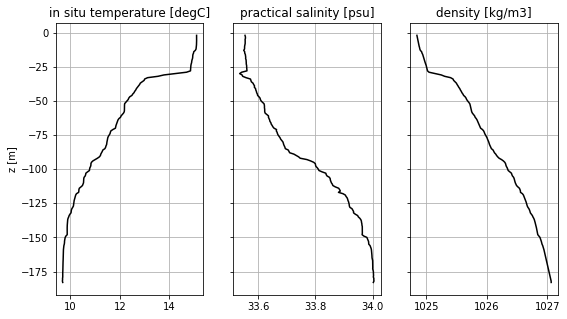

In [2]:
data_dir = '/Users/aponte/Current_projects/cognac/minions/'
mat_file = data_dir+'MinionData_for_Aurelien.mat'

def parse_minion_mat(mat_file):

    d = sio.loadmat(mat_file)

    ctd={}
    for v, i in zip(['rho', 'sigma0', 'z', 'temperature', 'salinity'],
                    range(5),
                   ):
        ctd[v] = d['profile'][0][0][i].squeeze()

    ctd['lon'] = -122
    ctd['lat'] = 37

    ctd['pressure'] = gsw.p_from_z(ctd['z'], ctd['lat'])

    return ctd

ctd = parse_minion_mat(mat_file)

w = fl.waterp(**ctd)

w

---

## instantiate float

The float is less compressible than water here and naturally stable.

In [3]:
#
f = fl.autonomous_float(model='minion')
print(f)

infer mass from volume with rho=1030 kg/m3, m = 2.621 kg
Float parameters: 
  L     = 0.40 m      - float length
  r     = 0.04 m      - float radius
  m     = 2.62 kg     - float mass
  V     = 2.54e+03 cm^3   - float volume
  rho_cte = m/V = 1.03e+09 kg.cm^3   - float baseline density
  gamma = 3.51e-06 /dbar  - mechanical compressibility
  gamma x V = 8.93e-03 cm^3/dbar  - normalized compressibility
  alpha = 1.20e-05 /degC  - thermal compressibility
  alpha x V = 3.05e-02 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1



In [4]:
# adjust mass to target one depth

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp, N2 = w.get_rho(z), w.get_p(z), w.get_temp(z), w.get_N2(z)

# adjust mass to be at equilibrium at 0m and substract 5g
z_equilibrium = -40.
iz = np.argmin(np.abs(z-z_equilibrium))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=0.)

f0 = deepcopy(f)

-11.3 g  were added to the float in order to be at equilibrium at 40 dbar 



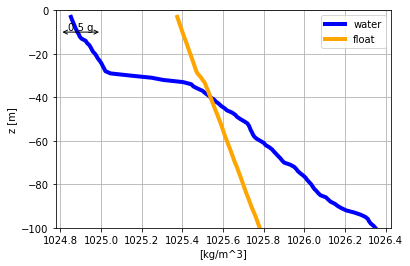

In [5]:
fl.plot_float_density(z, f, w)

---
### no isopycnal displacement

In [6]:
T = 2*3600.

f.time_step(w, 
            T=T, 
            dt_step=1., 
            dt_store=10., 
            z=-5., w=0.,
           )

Start time stepping for 120 min ...
... time stepping done


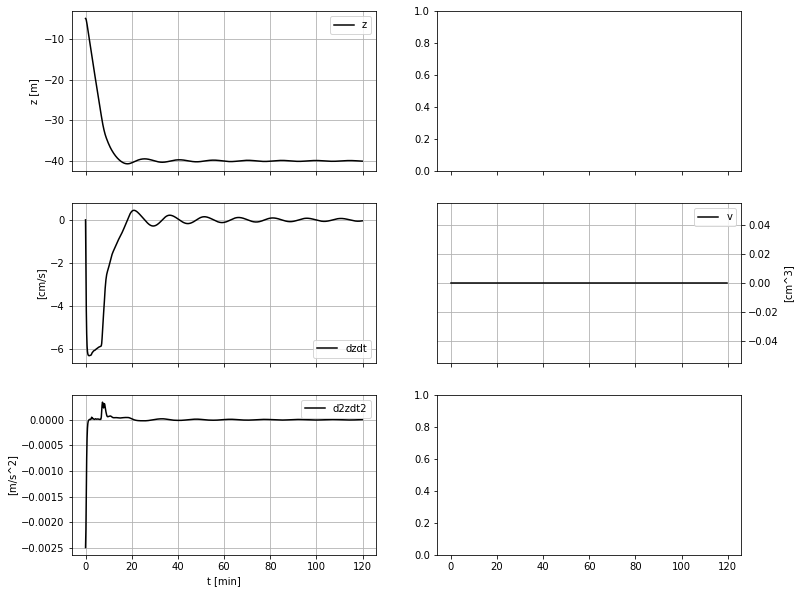

In [7]:
f.plot_logs()

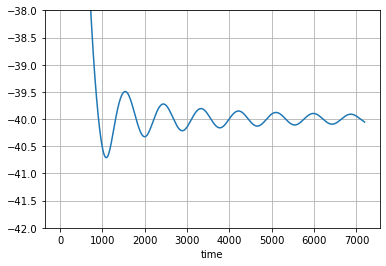

In [8]:
ax = plt.subplot(111)
f.log['state']['z'].plot(ylim=(-42,-38), ax=ax)
ax.grid()

---
### with isopycnal displacement

In [9]:
f = deepcopy(f0)

In [10]:
# isopycnal displacement
amplitude = 2. # m
period = 10 # min

eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)

In [11]:
# simulation
f.time_step(w, 
            T=T, 
            dt_step=1., 
            dt_store=10., 
            z=-5., w=0.,
            eta=eta,
           )

Start time stepping for 120 min ...
... time stepping done


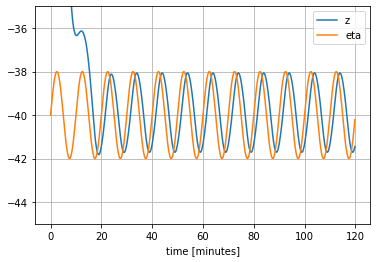

In [12]:
ax = plt.subplot(111)

df = f.log['state']._df

df['time [minutes]'] = df.time/60.
df = df.set_index('time [minutes]')

df['eta'] = eta(df.time)
df['detadt'] = df.eta.diff()/df.time.diff()

df['z'].plot(ax=ax, ylim=(-45,-35)) #ylim=(-50,-30), ax=ax)
(df['eta']-40).plot(ax=ax)

ax.legend()

ax.grid()

In [13]:
f.log['dynamics'].plot_bk(gridded=False)

Loading BokehJS ...

array([<matplotlib.axes._subplots.AxesSubplot object at 0x14601a0d0>,
      dtype=object)

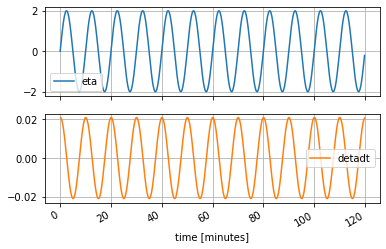

In [14]:
df[['eta','detadt']].plot(subplots=True, grid=True)

---

### sensibility to iwave frequency

In [15]:
F = {}

periods = [5, 10, 20, 40]
for period in periods:
    
    f = deepcopy(f0)
    
    eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)
    
    f.time_step(w, 
                T=T, 
                dt_step=1., 
                dt_store=10., 
                z=-5., w=0.,
                eta=eta,
               )
    
    eta = eta(f.log['state']._df.time)
    F[period] = (f, eta)

Start time stepping for 120 min ...
... time stepping done
Start time stepping for 120 min ...
... time stepping done
Start time stepping for 120 min ...
... time stepping done
Start time stepping for 120 min ...
... time stepping done


In [16]:
def massage_logs(F):
    states = []
    
    for key, value in F.items():
        
        f = value[0]
        eta = value[1]
        
        df = f.log['state']._df

        df['eta'] = eta #(df.time)
        df['detadt'] = df.eta.diff()/df.time.diff()

        df['time [minutes]'] = df.time/60.
        df = df.set_index('time [minutes]')
    
        states.append(df.to_xarray())
        
    return states

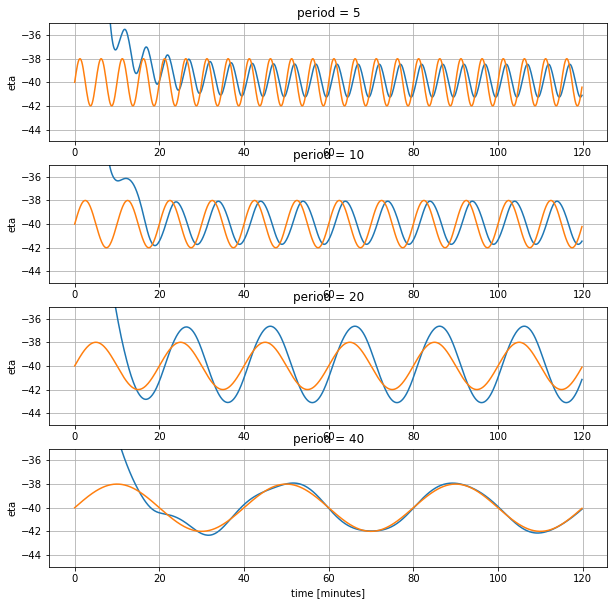

In [17]:
        
ds = xr.concat(massage_logs(F), dim='period').assign_coords(period=periods)

fig, axes = plt.subplots(4,1, figsize=(10,10))
for p, ax in zip(periods, axes):
    _ds = ds.sel(period=p)
    _ds.z.plot(ax=ax, ylim=(-45,-35))
    (_ds.eta-40).plot(ax=ax)
    ax.grid()
    if p!=periods[-1]:
        ax.set_xlabel('')    

In [18]:
F[5][0].log['dynamics'].plot_bk(gridded=False)

Loading BokehJS ...

In [19]:
F[40][0].log['dynamics'].plot_bk(gridded=False)

Loading BokehJS ...

In [20]:
F = {}

period = 40
amplitudes = [1, 10, 20]
for amplitude in amplitudes:
    
    f = deepcopy(f0)
    
    eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)
    
    f.time_step(w, 
                T=T, 
                dt_step=1., 
                dt_store=10., 
                z=-5., w=0.,
                eta=eta,
               )
    
    eta = eta(f.log['state']._df.time)
    F[amplitude] = (f, eta)

Start time stepping for 120 min ...
... time stepping done
Start time stepping for 120 min ...
... time stepping done
Start time stepping for 120 min ...
... time stepping done


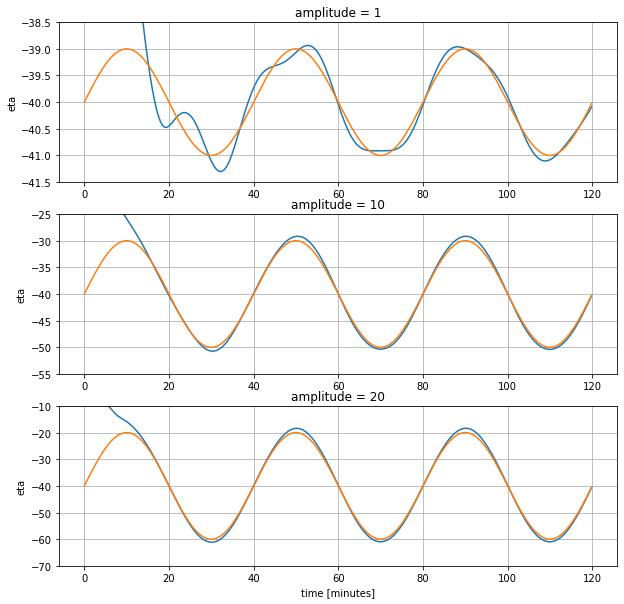

In [21]:
ds = xr.concat(massage_logs(F), dim='amplitude').assign_coords(amplitude=amplitudes)

fig, axes = plt.subplots(3,1, figsize=(10,10))
for a, ax in zip(amplitudes, axes):
    _ds = ds.sel(amplitude=a)
    _ds.z.plot(ax=ax, ylim=(-40-a*1.5,-40+a*1.5))
    (_ds.eta-40).plot(ax=ax)
    ax.grid()
    if a!=amplitudes[-1]:
        ax.set_xlabel('')

--- 

### sensibility to compressibility

there should be little

infer mass from volume with rho=1030 kg/m3, m = 2.621 kg
-11.0 g  were added to the float in order to be at equilibrium at 40 dbar 

Start time stepping for 120 min ...
... time stepping done
infer mass from volume with rho=1030 kg/m3, m = 2.621 kg
-11.3 g  were added to the float in order to be at equilibrium at 40 dbar 

Start time stepping for 120 min ...
... time stepping done
infer mass from volume with rho=1030 kg/m3, m = 2.621 kg
-11.7 g  were added to the float in order to be at equilibrium at 40 dbar 

Start time stepping for 120 min ...
... time stepping done


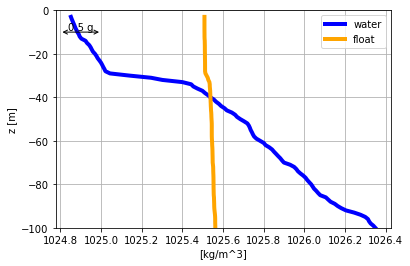

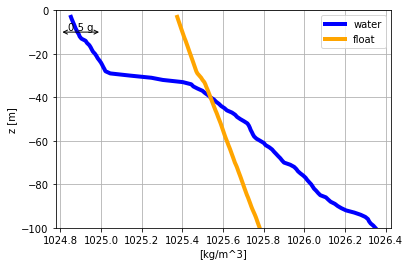

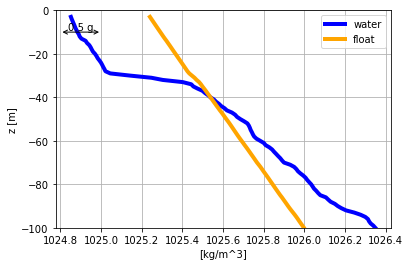

In [22]:

gammas = [0., f.gamma, f.gamma*2.]

F = {}
for gamma in gammas:

    f = fl.autonomous_float(model='minion', gamma=gamma)

    # adjust mass to target one depth
    z=np.arange(-100.,0.,1.)
    rho_w, p, temp, N2 = w.get_rho(z), w.get_p(z), w.get_temp(z), w.get_N2(z)
    # adjust mass to be at equilibrium at 0m and substract 5g
    z_equilibrium = -40.
    iz = np.argmin(np.abs(z-z_equilibrium))
    f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=0.)

    fl.plot_float_density(z, f, w)

    period = 40
    amplitude = 10
    eta = lambda t: amplitude*np.sin(2.*np.pi/(60.*period)*t)    
    
    f.time_step(w, 
                T=T, 
                dt_step=1., 
                dt_store=10., 
                z=-5., w=0.,
                eta=eta,
               )

    eta = eta(f.log['state']._df.time)
    F[gamma] = (f, eta)

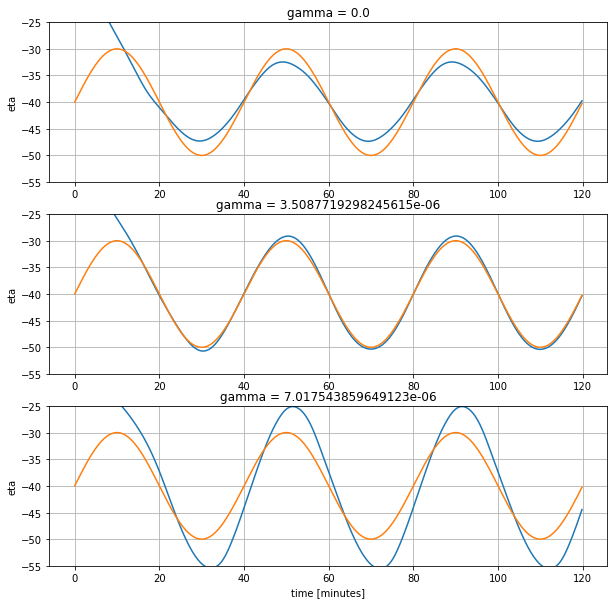

In [23]:
ds = xr.concat(massage_logs(F), dim='gamma').assign_coords(gamma=gammas)

fig, axes = plt.subplots(3,1, figsize=(10,10))
for a, ax in zip(gammas, axes):
    _ds = ds.sel(gamma=a)
    _ds.z.plot(ax=ax, ylim=(-40-amplitude*1.5,-40+amplitude*1.5))
    (_ds.eta-40).plot(ax=ax)
    ax.grid()
    if a!=gammas[-1]:
        ax.set_xlabel('')

---

### stratification, leading terms

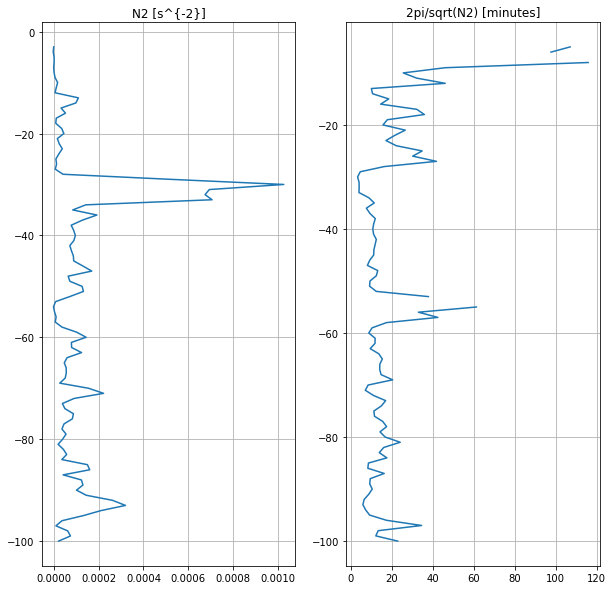

In [24]:
fig, axes = plt.subplots(1,2, figsize=(10,10))
ax = axes[0]
ax.plot(N2, z)
ax.set_title('N2 [s^{-2}]')
ax.grid()
#
ax = axes[1]
ax.plot(2*np.pi/np.sqrt(N2)/60, z)
ax.set_title('2pi/sqrt(N2) [minutes]')
ax.grid()

In [25]:
w.get_compressibility(z)

array([4.37231628e-06, 4.37221441e-06, 4.37180948e-06, 4.37168625e-06,
       4.37180642e-06, 4.37152787e-06, 4.37061938e-06, 4.36905760e-06,
       4.36751752e-06, 4.36615767e-06, 4.36552712e-06, 4.36546540e-06,
       4.36517013e-06, 4.36468173e-06, 4.36436358e-06, 4.36297352e-06,
       4.36254417e-06, 4.36237734e-06, 4.36202969e-06, 4.36199769e-06,
       4.36200042e-06, 4.36192165e-06, 4.36183917e-06, 4.36180964e-06,
       4.36149651e-06, 4.36094633e-06, 4.36046234e-06, 4.36034310e-06,
       4.36006937e-06, 4.35857623e-06, 4.35681785e-06, 4.35672615e-06,
       4.35667577e-06, 4.35645442e-06, 4.35613791e-06, 4.35594579e-06,
       4.35569213e-06, 4.35508681e-06, 4.35398163e-06, 4.35364726e-06,
       4.35294938e-06, 4.35215966e-06, 4.35172207e-06, 4.35169393e-06,
       4.35176352e-06, 4.35182734e-06, 4.35198953e-06, 4.35209590e-06,
       4.35208387e-06, 4.35147571e-06, 4.35060983e-06, 4.34983724e-06,
       4.34955349e-06, 4.34890462e-06, 4.34744641e-06, 4.34693212e-06,
      

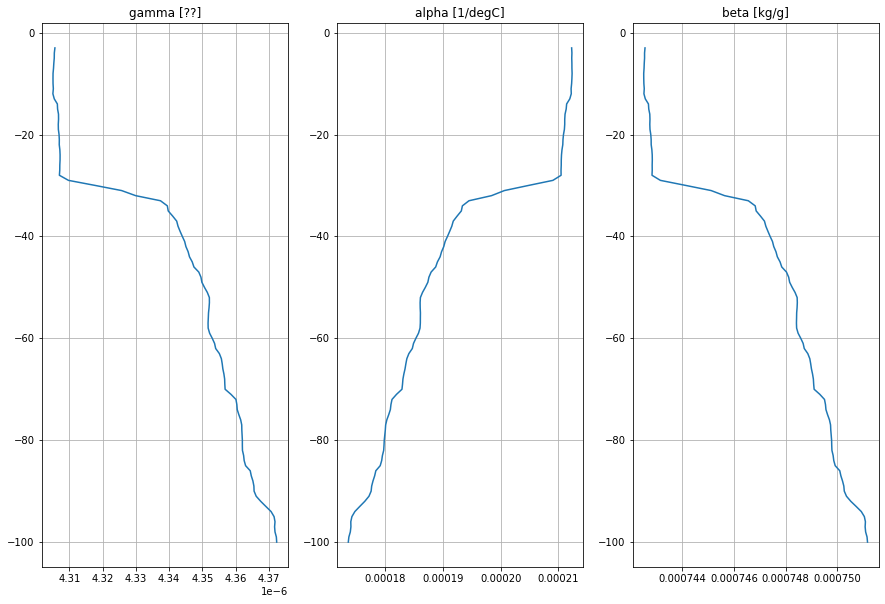

In [26]:

gamma = w.get_compressibility(z)
alpha = w.get_alpha(z)
beta = w.get_beta(z)

fig, axes = plt.subplots(1,3, figsize=(15,10))
ax = axes[0]
ax.plot(gamma, z)
ax.set_title('gamma [??]')
ax.grid()
#
ax = axes[1]
ax.plot(alpha, z)
ax.set_title('alpha [1/degC]')
ax.grid()
#
ax = axes[2]
ax.plot(beta, z)
ax.set_title('beta [kg/g]')
ax.grid()


Response to periodic isopycnal motions:

\begin{align}
\big [ (1+a) \omega^2 
- i c_d \omega  
+ g (\partial_z \rho_w/\rho_0 - \gamma + \alpha \partial_z T)
\big ] \hat \eta_f
=
\Big \{ g\partial_z \rho_w/\rho_0
+ \big [ a \omega^2 - i\omega c_d \big ]  \Big \} \hat \eta.
\label{eq:zf_omega}
\end{align}

$ \partial_z \rho_w/\rho_0 \sim 2 \; 10^{-5} 1/m$

$ \gamma \sim 3.5 \; 10^{-6} 1/m$

$ \alpha_f \partial_z T \sim 4 \; 10^{-6} 1/m$

$\omega \sim 5 \; 10^{-3} $

$c_d \sim w/L \sim 10^{-2} 1/s^2$

$c_d \omega /g \sim 5 \; 10^{-6} 1/m$

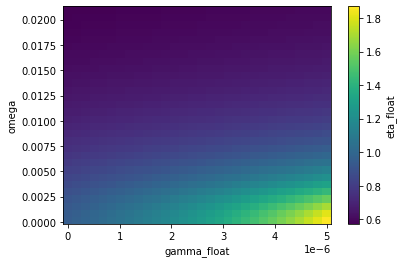

In [98]:
def get_eta_float(**kwargs):
    p = {'omega': 2*np.pi/(20*60),
         'a': 1.,
         'cd': 1e-2/1.,
         'drhowdz': 1/100.,
         'dTdz': 2./50.,
         'alpha_float': 1.2*1e-5,
         'gamma_float': 3.5e-6,
         'rho0': 1030.,
        }
    p.update(kwargs)
    ds = xr.Dataset()
    for k, v in p.items():
        if isinstance(v, tuple):
            if len(v)>2:
                num = v[2]
            else:
                num = 30
            #p[k] = xr.DataArray(np.linspace(v[0], v[1], num=num), dims=[k], name=k).reset_coords()
            ds = ds.assign_coords(**{k: xr.DataArray(np.linspace(v[0], v[1], num=num), 
                                                dims=[k], name=k
                                               )
                               }
                            )
        else:
            ds = ds.assign_attrs(**{k: v})
    g = 9.81
    ds['eta_float'] = (g*ds.drhowdz/ds.rho0 
                       + ds.a*ds.omega**2 
                       - 1j * ds.cd*ds.omega 
                      ) /( (1+ds.a)*ds.omega**2 
                          - 1j*ds.cd*ds.omega 
                          + g*(ds.drhowdz/ds.rho0 
                               - ds.gamma_float 
                               + ds.alpha_float*ds.dTdz
                              )
                         )
    return ds


ds = get_eta_float(omega=(2*np.pi/(10*60*60), 2*np.pi/(5*60)), 
                   gamma_float=(0.,5e-6), 
                   drhowdz=1/100., 
                   dTdz=2/50,
                  )

abs(ds.eta_float).plot()

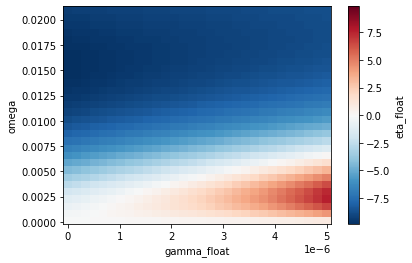

In [97]:
(xr.apply_ufunc(np.angle, ds.eta_float)*180/np.pi).plot()